In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

2024-09-10 15:26:42.718975: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-10 15:26:42.753911: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-10 15:26:42.753930: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-10 15:26:42.755084: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-10 15:26:42.761626: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


/home/amarinai/miniconda3/envs/bcfind/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Define FDA method

In [46]:
def low_freq_mutate_np( amp_src, amp_trg, L=0.1 ):
    amp_src = tf.signal.fftshift(amp_src, axes=(0, 1, 2))
    amp_trg = tf.signal.fftshift(amp_trg, axes=(0, 1, 2))

    amp_src1 = amp_src
    amp_trg1 = amp_trg

    d, h, w = amp_src.shape
    b = (  np.floor(np.amin((h,w,d))*L) ).astype(int)
    c_h = np.floor(h/2.0).astype(int)
    c_w = np.floor(w/2.0).astype(int)
    c_z = np.floor(d/2.0).astype(int)

    print(b)
    h1, h2 = c_h - b, c_h + b + 1
    w1, w2 = c_w - b, c_w + b + 1
    d1, d2 = c_z - b, c_z + b + 1



    amp_src = amp_src.numpy()
    amp_trg = amp_trg.numpy()
    amp_src[d1:d2,h1:h2,w1:w2] = 0.6 * amp_trg[d1:d2,h1:h2,w1:w2] + 0.4 * amp_src[d1:d2,h1:h2,w1:w2]
    amp_src = tf.convert_to_tensor(amp_src)
    amp_src = tf.signal.ifftshift( amp_src, axes=(0, 1, 2) )
    return amp_src, amp_src1, amp_trg1


def FDA_source_to_target_np(src_img, trg_img, L=0.1 ):
    fft_src = tf.signal.fft3d(tf.cast(src_img, tf.complex64))
    fft_trg = tf.signal.fft3d(tf.cast(trg_img, tf.complex64))

    # Get amplitude and phase of source and target
    amp_src, pha_src = tf.abs(fft_src), tf.math.angle(fft_src)
    amp_trg, _ = tf.abs(fft_trg), tf.math.angle(fft_trg)

    # mutate the amplitude part of source with target
    amp_src_, amp_src1, amp_trg1 = low_freq_mutate_np( amp_src, amp_trg, L=L )

    # mutated fft of source
    fft_src_ = tf.complex(amp_src_, tf.zeros_like(amp_src_)) * tf.exp(tf.complex(tf.zeros_like(pha_src), pha_src))

    # Perform inverse FFT to get the transformed source image
    src_in_trg = tf.signal.ifft3d(fft_src_)

    # Return the transformed image and label
    return tf.math.real(src_in_trg), amp_src1, amp_trg1


def apply_fda_transformation_img_tf(src_img, y, trg_img, L=0.1):
    ret, amp_src, amp_trg = FDA_source_to_target_np(src_img, trg_img, L)

    return tf.convert_to_tensor(ret), y, amp_src, amp_trg 



Load Images sampled randomly from base_path and base_path_src 

In [35]:
import random
import tifffile
import os

gpu=1

gpus = tf.config.list_physical_devices("GPU")
tf.config.set_visible_devices(gpus[gpu], "GPU")

base_path = "/home/amarinai/Data/Broca_old_l48_long/Tiff_files/Train"
fnames = os.listdir(base_path)
trg_path = random.choice(fnames)
print(trg_path)

path = f"{base_path}/{trg_path}"
trg_img = tifffile.imread(path)

trg_img[trg_img>2**15] = 2**15
trg_img = trg_img/2**15

base_path_src = "/home/amarinai/Data/Broca_I45_95crops/Tiff_files/Train"
fnames = os.listdir(base_path_src)
path = random.choice(fnames)
print(path)

path = f"{base_path_src}/{path}"
img = tifffile.imread(path)

img[img>2**15] = 2**15
img = img/2**15

img = tf.convert_to_tensor(img)
trg_img = tf.convert_to_tensor(trg_img)


slice_1_pos_91_5423_6457_dim_50_100_100_1.tif
crop_13.tif


'\nimg = tf.expand_dims(img, 0)\ntrg_img = tf.expand_dims(trg_img, 0)\n\nimg = tf.expand_dims(img, -1)\ntrg_img = tf.expand_dims(trg_img, -1)\n'

Apply FDA to img and trg_img

In [47]:
img_modifier, _, amp_src, amp_trg  = apply_fda_transformation_img_tf(img, 0, trg_img, L=0.3)

15


Plot the spectrum amplitude


Text(0.5, 1.0, 't ')

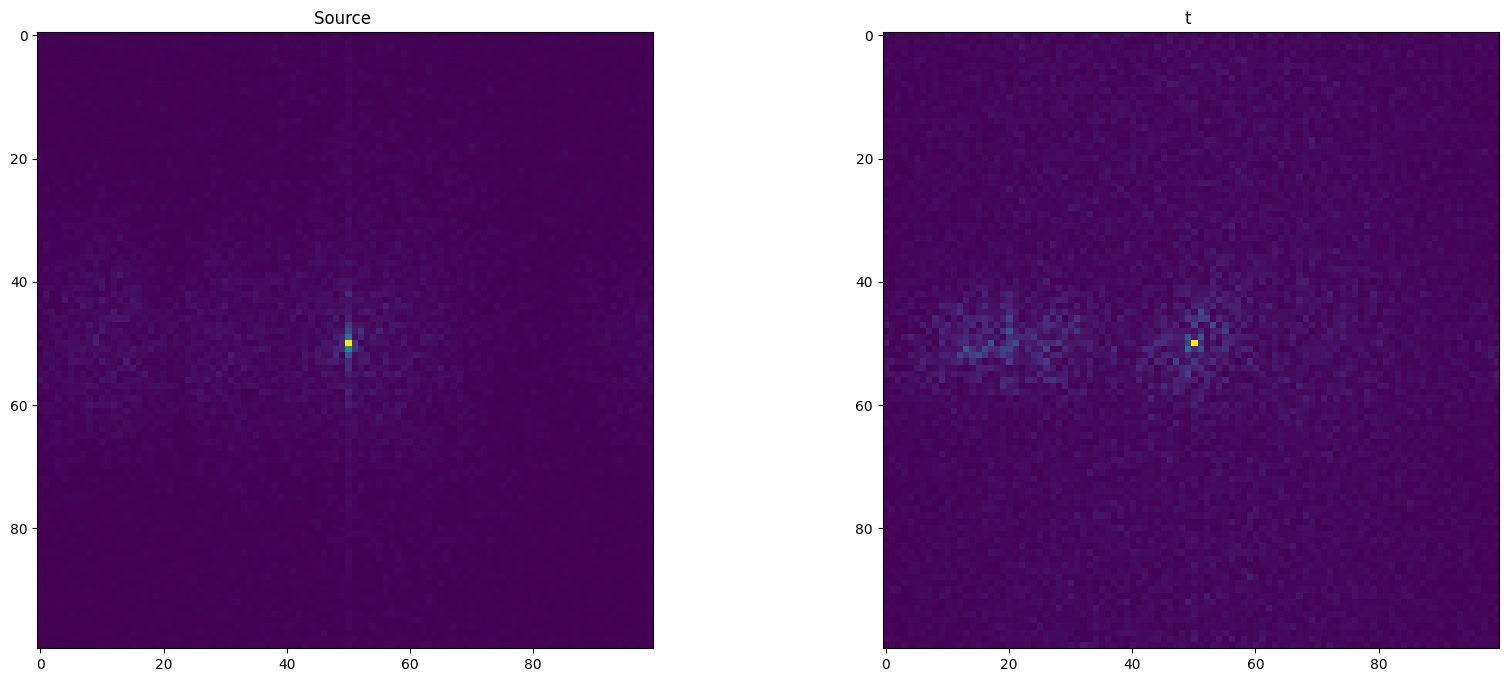

In [44]:
plt.figure(figsize=[20,8])

plt.subplot(121)
plt.imshow(amp_src[10])
plt.title("Source ")
plt.subplot(122)
plt.imshow(amp_trg[10])
plt.title("t ")


MIP

In [14]:
plt.figure(figsize=[20,8])


plt.subplot(161)
plt.imshow(img[...].numpy().max(0), vmin=0, vmax=1)
plt.title("Source " + str(img.numpy().mean()))


plt.subplot(162)
plt.imshow(img[...].numpy().max(0))
plt.title("Source not normalized")
plt.subplot(163)
plt.imshow(img_modifier[...].numpy().max(0), vmin=0, vmax=1)
plt.title("Modified " + str(img_modifier.numpy().mean()))
plt.subplot(164)
plt.imshow(img_modifier[...].numpy().max(0))
plt.title("Modified not normalized")

plt.subplot(165)
plt.imshow(trg_img[...].numpy().max(0), vmin=0, vmax=1)
plt.title("Target " + str(trg_img.numpy().mean()))

plt.subplot(166)
plt.imshow(trg_img[...].numpy().max(0))
plt.title("Target not normalized")



Text(0.5, 1.0, 'Target not normalized')

Slice of depth z0

Text(0.5, 1.0, 'Target not normalized')

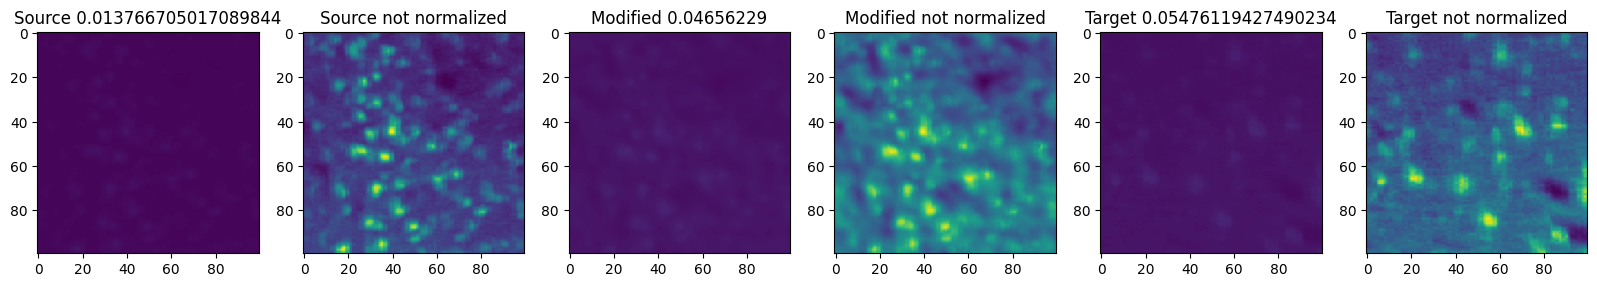

In [45]:
plt.figure(figsize=[20,8])

z0 = 10
plt.subplot(161)
plt.imshow(img[...].numpy()[z0], vmin=0, vmax=1)
plt.title("Source " + str(img.numpy().mean()))


plt.subplot(162)
plt.imshow(img[...].numpy()[z0])
plt.title("Source not normalized")
plt.subplot(163)
plt.imshow(img_modifier[...].numpy()[z0], vmin=0, vmax=1)
plt.title("Modified " + str(img_modifier.numpy().mean()))
plt.subplot(164)
plt.imshow(img_modifier[...].numpy()[z0])
plt.title("Modified not normalized")

plt.subplot(165)
plt.imshow(trg_img[...].numpy()[z0], vmin=0, vmax=1)
plt.title("Target " + str(trg_img.numpy().mean()))

plt.subplot(166)
plt.imshow(trg_img[...].numpy()[z0])
plt.title("Target not normalized")

Some examples

Text(0.5, 1.0, 'Target not normalized')

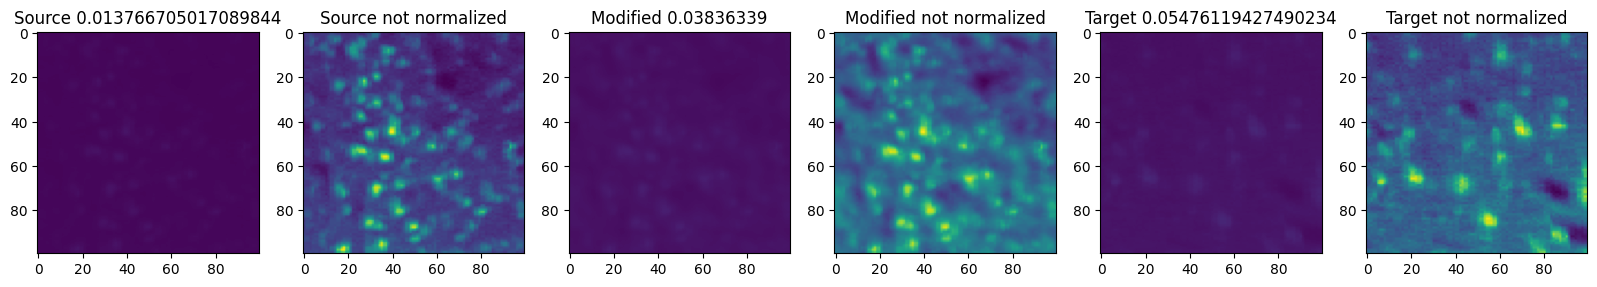

In [48]:
plt.figure(figsize=[20,8])

z0 = 10
plt.subplot(161)
plt.imshow(img[...].numpy()[z0], vmin=0, vmax=1)
plt.title("Source " + str(img.numpy().mean()))


plt.subplot(162)
plt.imshow(img[...].numpy()[z0])
plt.title("Source not normalized")
plt.subplot(163)
plt.imshow(img_modifier[...].numpy()[z0], vmin=0, vmax=1)
plt.title("Modified " + str(img_modifier.numpy().mean()))
plt.subplot(164)
plt.imshow(img_modifier[...].numpy()[z0])
plt.title("Modified not normalized")

plt.subplot(165)
plt.imshow(trg_img[...].numpy()[z0], vmin=0, vmax=1)
plt.title("Target " + str(trg_img.numpy().mean()))

plt.subplot(166)
plt.imshow(trg_img[...].numpy()[z0])
plt.title("Target not normalized")

KDE of the images

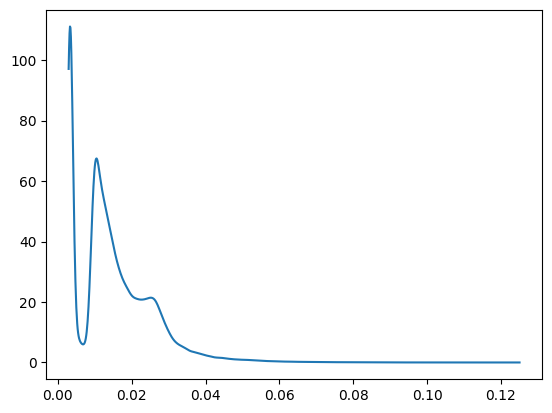

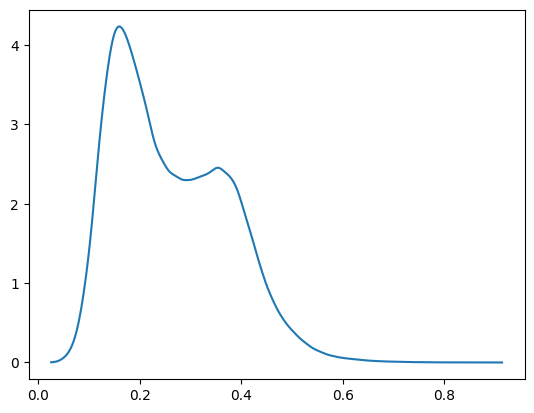

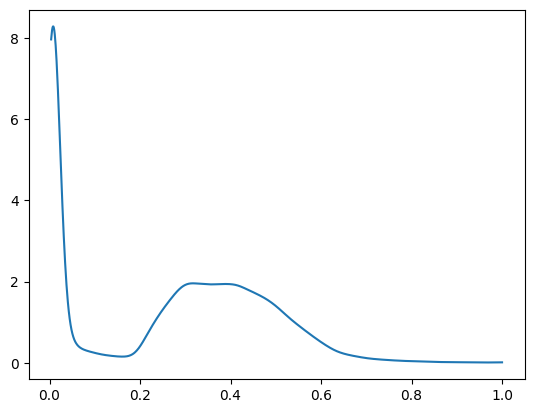

In [383]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(img.numpy().flatten())

x_values = np.linspace(min(img.numpy().flatten()), max(img.numpy().flatten()), 1000)

plt.plot(x_values, kde(x_values))
plt.show()

kde = gaussian_kde(img_modifier.numpy().flatten())

x_values = np.linspace(min(img_modifier.numpy().flatten()), max(img_modifier.numpy().flatten()), 1000)

plt.plot(x_values, kde(x_values))
plt.show()

kde = gaussian_kde(trg_img.numpy().flatten())

x_values = np.linspace(min(trg_img.numpy().flatten()), max(trg_img.numpy().flatten()), 1000)

plt.plot(x_values, kde(x_values))
plt.show()





(50, 100, 100)


Text(0.5, 1.0, 'Target not normalized')

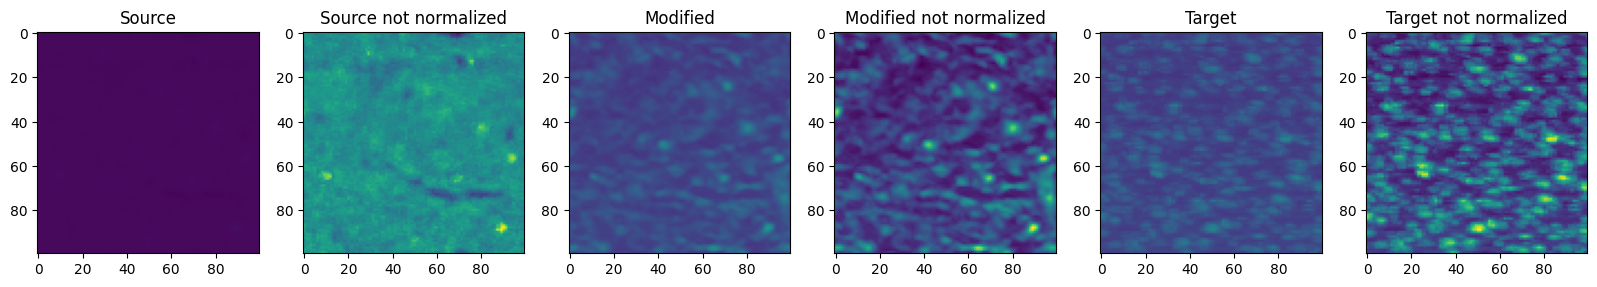

In [330]:
plt.figure(figsize=[20,8]) #


plt.subplot(161)
plt.imshow(img[...].numpy().max(0), vmin=0, vmax=1)
plt.title("Source")


plt.subplot(162)
plt.imshow(img[...].numpy().max(0))
plt.title("Source not normalized")
plt.subplot(163)
plt.imshow(img_modifier[...].numpy().max(0), vmin=0, vmax=1)
plt.title("Modified")
plt.subplot(164)
plt.imshow(img_modifier[...].numpy().max(0))
plt.title("Modified not normalized")

plt.subplot(165)
plt.imshow(trg_img[...].numpy().max(0), vmin=0, vmax=1)
plt.title("Target")

plt.subplot(166)
plt.imshow(trg_img[...].numpy().max(0))
plt.title("Target not normalized")

(50, 100, 100)


Text(0.5, 1.0, 'Target not normalized')

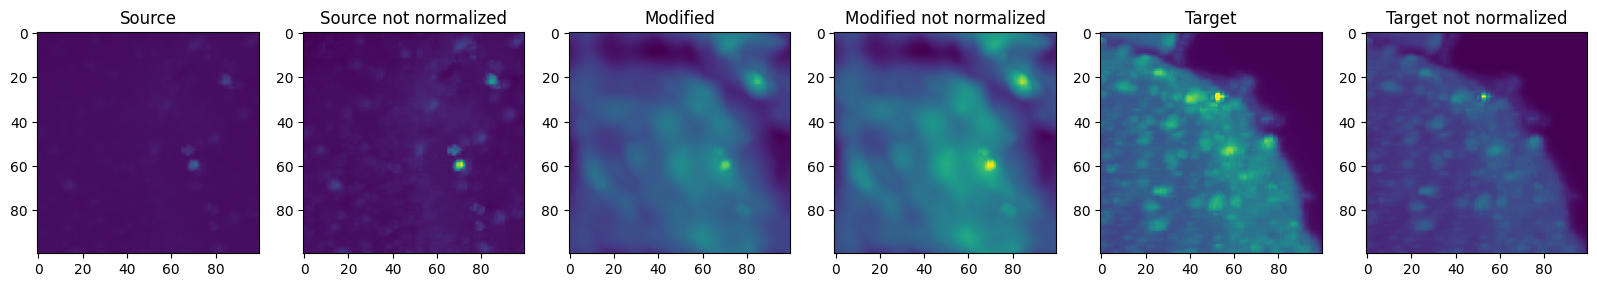

In [314]:
print(img.shape)   #L = 0.1

plt.figure(figsize=[20,8])


plt.subplot(161)
plt.imshow(img[...].numpy().max(0), vmin=0, vmax=0.5)
plt.title("Source")


plt.subplot(162)
plt.imshow(img[...].numpy().max(0))
plt.title("Source not normalized")
plt.subplot(163)
plt.imshow(img_modifier[...].numpy().max(0), vmin=0, vmax=0.5)
plt.title("Modified")
plt.subplot(164)
plt.imshow(img_modifier[...].numpy().max(0))
plt.title("Modified not normalized")

plt.subplot(165)
plt.imshow(trg_img[...].numpy().max(0), vmin=0, vmax=0.5)
plt.title("Target")

plt.subplot(166)
plt.imshow(trg_img[...].numpy().max(0))
plt.title("Target not normalized")
